In [1]:
import torch
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np
import torch
import triton
import triton.language as tl
from fasta import *

In [22]:
# ------------------------------------------------------------------------------
# Helpers
# ------------------------------------------------------------------------------
def nearest_power_of_2(x):
    """Find the nearest power of 2 >= x, clamped at 16 minimum."""
    return max(16, 2 ** round(math.log2(x)))


def generate_minhash_indices(k, D, seed=0):
    """
    Generate 'k' random indices in [0, D) for MinHash approximation.
    This is a placeholder for a true MinHash approach.
    """
    rng = torch.Generator()
    rng.manual_seed(seed)
    return torch.randint(0, D, (k,), generator=rng, dtype=torch.int32)


# ------------------------------------------------------------------------------
# Triton Kernel
# ------------------------------------------------------------------------------
@triton.jit
def fasta_minhash_kernel(
    Q_ptr, K_ptr, attn_ptr,
    minhash_indices_ptr,             # random dimension indices
    K_MINHASH: tl.constexpr,         # # of sampled dims, compile-time

    B: tl.constexpr,
    H: tl.constexpr,
    N: tl.constexpr,
    D: tl.constexpr,
    BLOCK_SIZE: tl.constexpr,

    # Strides
    stride_qb, stride_qh, stride_q0, stride_q1,
    stride_kb, stride_kh, stride_k0, stride_k1,
    stride_attnb, stride_attnh, stride_attn0, stride_attn1,
):
    """
    Triton kernel for block-wise attention:
      - Diagonal blocks => exact dot-product (full dimension)
      - Off-diagonal => approximate with vectorized MinHash

    We define pointer variables only inside each branch to avoid Triton's 
    type unification error (since shapes differ for diag vs. off-diag).
    """
    pid = tl.program_id(0)
    n_blocks = tl.cdiv(N, BLOCK_SIZE)

    b_idx = pid // (H * n_blocks * n_blocks)
    head_idx = (pid // (n_blocks * n_blocks)) % H
    block_idx = pid % (n_blocks * n_blocks)
    row_block_idx = block_idx // n_blocks
    col_block_idx = block_idx % n_blocks

    row_start = row_block_idx * BLOCK_SIZE
    col_start = col_block_idx * BLOCK_SIZE

    # We'll store the final [BLOCK_SIZE, BLOCK_SIZE] block in 'acc'
    acc = tl.zeros((BLOCK_SIZE, BLOCK_SIZE), dtype=tl.float32)

    # Check if block is diagonal
    is_diag = (row_block_idx == col_block_idx)

    # ----------------------------------------------------------------
    # Diagonal Block => Exact Dot Product
    # ----------------------------------------------------------------
    if is_diag:
        offs_d = tl.arange(0, D)                          # shape [D]
        offs_q = row_start + tl.arange(0, BLOCK_SIZE)     # shape [BLOCK_SIZE]
        offs_k = col_start + tl.arange(0, BLOCK_SIZE)     # shape [BLOCK_SIZE]

        # Pointers for Q => shape [BLOCK_SIZE, D]
        q_ptrs_diag = (
            Q_ptr
            + b_idx * stride_qb
            + head_idx * stride_qh
            + offs_q[:, None] * stride_q0
            + offs_d[None, :] * stride_q1
        )
        # Pointers for K => shape [BLOCK_SIZE, D]
        k_ptrs_diag = (
            K_ptr
            + b_idx * stride_kb
            + head_idx * stride_kh
            + offs_k[:, None] * stride_k0
            + offs_d[None, :] * stride_k1
        )

        q_mask = (offs_q[:, None] < N)
        k_mask = (offs_k[:, None] < N)

        # Load entire sub-block
        q_block = tl.load(q_ptrs_diag, mask=q_mask, other=0.0)  # [BLOCK_SIZE, D]
        k_block = tl.load(k_ptrs_diag, mask=k_mask, other=0.0)  # [BLOCK_SIZE, D]

        # Dot => [BLOCK_SIZE, BLOCK_SIZE]
        acc = tl.dot(q_block, tl.trans(k_block))

    # ----------------------------------------------------------------
    # Off-Diagonal => Approx w/ MinHash (Vectorized)
    # ----------------------------------------------------------------
    else:
        # 1) gather k_minhash dimension indices => shape [k_minhash]
        dim_ids = tl.load(minhash_indices_ptr + tl.arange(0, K_MINHASH))  # e.g., [0..k_minhash]

        # 2) row offsets => shape [BLOCK_SIZE]
        row_offs = row_start + tl.arange(0, BLOCK_SIZE)
        col_offs = col_start + tl.arange(0, BLOCK_SIZE)

        # reshape to 2D
        row_offs_2d = tl.reshape(row_offs, (BLOCK_SIZE, 1))   # [BLOCK_SIZE, 1]
        col_offs_2d = tl.reshape(col_offs, (BLOCK_SIZE, 1))   # [BLOCK_SIZE, 1]
        dim_ids_2d  = tl.reshape(dim_ids, (1, K_MINHASH))     # [1, K_MINHASH]

        # Pointers for Q => shape [BLOCK_SIZE, k_minhash]
        q_ptrs_offdiag = (
            Q_ptr
            + b_idx * stride_qb
            + head_idx * stride_qh
            + row_offs_2d * stride_q0
            + dim_ids_2d * stride_q1
        )
        # Pointers for K => shape [BLOCK_SIZE, k_minhash]
        k_ptrs_offdiag = (
            K_ptr
            + b_idx * stride_kb
            + head_idx * stride_kh
            + col_offs_2d * stride_k0
            + dim_ids_2d * stride_k1
        )

        # Masks
        q_mask_rows = row_offs_2d < N      # [BLOCK_SIZE,1]
        k_mask_rows = col_offs_2d < N      # [BLOCK_SIZE,1]
        # dims must be < D
        q_mask_dims = dim_ids_2d < D       # [1, k_minhash]
        # combine for 2D
        q_mask_2d = q_mask_rows & q_mask_dims  # [BLOCK_SIZE, k_minhash]
        k_mask_2d = k_mask_rows & q_mask_dims  # [BLOCK_SIZE, k_minhash]

        # Load => shape [BLOCK_SIZE, k_minhash]
        q_approx = tl.load(q_ptrs_offdiag, mask=q_mask_2d, other=0.0)
        k_approx = tl.load(k_ptrs_offdiag, mask=k_mask_2d, other=0.0)

        # single matmul => [BLOCK_SIZE, BLOCK_SIZE]
        block_attn_approx = tl.dot(q_approx, tl.trans(k_approx))
        # scale
        inv_k = 1.0 / K_MINHASH
        acc = block_attn_approx * inv_k

    # ----------------------------------------------------------------
    # Store to attn
    # ----------------------------------------------------------------
    offs_attn_i = row_start + tl.arange(0, BLOCK_SIZE)
    offs_attn_j = col_start + tl.arange(0, BLOCK_SIZE)
    attn_ptrs = (
        attn_ptr
        + b_idx * stride_attnb
        + head_idx * stride_attnh
        + offs_attn_i[:, None] * stride_attn0
        + offs_attn_j[None, :] * stride_attn1
    )

    out_of_bounds = (offs_attn_i[:, None] >= N) | (offs_attn_j[None, :] >= N)
    tl.store(attn_ptrs, acc, mask=~out_of_bounds)


# ------------------------------------------------------------------------------
# Top-level Python Function
# ------------------------------------------------------------------------------
def fasta_minhash_attn(Q, K, k_minhash=64, seed=0):
    """
    Approximate block-wise attention:
      -- Diagonal blocks => exact dot-product
      -- Off-diagonal blocks => MinHash-based approximation

    Args:
      Q, K: [B, H, N, D]  (must be contiguous or .contiguous() is called)
      k_minhash (int): number of random dims sampled
      seed (int): random seed for reproducibility
    Returns:
      attn: [B, H, N, N]  approximate attention
    """
    B, H, N, D = Q.shape

    # block_size ~ sqrt(N), clamp to nearest power-of-2
    block_size = int(min(nearest_power_of_2(math.isqrt(N)), N))

    # Force contiguity
    Q = Q.contiguous()
    K = K.contiguous()

    # Output
    attn = torch.zeros((B, H, N, N), device=Q.device, dtype=Q.dtype)

    # Random dims for MinHash
    minhash_indices = generate_minhash_indices(k_minhash, D, seed=seed).to(Q.device)

    n_blocks = (N + block_size - 1) // block_size
    grid = (B * H * n_blocks * n_blocks,)

    # Launch Triton kernel
    fasta_minhash_kernel[grid](
        Q, K, attn,
        minhash_indices,
        k_minhash,   # python int => tl.constexpr in kernel signature

        B, H, N, D,
        block_size,

        # Strides
        Q.stride(0), Q.stride(1), Q.stride(2), Q.stride(3),
        K.stride(0), K.stride(1), K.stride(2), K.stride(3),
        attn.stride(0), attn.stride(1), attn.stride(2), attn.stride(3),
    )
    return attn

In [23]:
def test_fasta_attention_benchmark(N, D, block_size, num_iterations):
    """
    Benchmark function for optimized FASTA attention implementation
    and standard self-attention. Includes batching for efficiency.
    """

    device = 'cuda'

    assert torch.cuda.is_available(), "CUDA is not available. Please run on a CUDA-enabled device."

    torch.manual_seed(0)
    Q = torch.randn(N, D, device=device, dtype=torch.float32)
    K = torch.randn(N, D, device=device, dtype=torch.float32)

    Q_fasta = Q.unsqueeze(0).unsqueeze(0)
    K_fasta = K.unsqueeze(0).unsqueeze(0)

    print("Computing standard self-attention for all iterations...")
    standard_times = []
    standard_outputs = []

    for idx in tqdm(range(num_iterations), desc="Standard Self-Attention"):
        start_std = torch.cuda.Event(enable_timing=True)
        end_std = torch.cuda.Event(enable_timing=True)

        start_std.record()
        attn_ref = Q @ K.T
        end_std.record()

        torch.cuda.synchronize()
        elapsed_std = start_std.elapsed_time(end_std)
        standard_times.append(elapsed_std)
        if idx % 1000 == 0:
            standard_outputs.append(attn_ref.detach().cpu().numpy())

    print("Computing optimized FASTA attention for all iterations...")
    fasta_times = []
    fasta_outputs = []

    for idx in tqdm(range(num_iterations), desc="FASTA Attention"):
        start_fasta = torch.cuda.Event(enable_timing=True)
        end_fasta = torch.cuda.Event(enable_timing=True)

        start_fasta.record()
        attn_fasta = fasta_minhash_attn(Q_fasta, K_fasta).squeeze(0).squeeze(0)
        end_fasta.record()

        torch.cuda.synchronize()
        elapsed_fasta = start_fasta.elapsed_time(end_fasta)
        fasta_times.append(elapsed_fasta)
        if idx % 1000 == 0:
            fasta_outputs.append(attn_fasta.detach().cpu().numpy())

    standard_times = np.array(standard_times)
    fasta_times = np.array(fasta_times)

    print("Computing error metrics...")
    mae_list = []
    max_error_list = []
    relative_error_list = []

    for ref, fasta in zip(standard_outputs, fasta_outputs):
        abs_diff = np.abs(ref - fasta)
        mae_list.append(abs_diff.mean().item())
        max_error_list.append(abs_diff.max().item())
        relative_error_list.append((abs_diff / np.abs(ref + 1e-6)).mean().item())

    print("Benchmarking completed!")
    print("\nTiming Statistics:")
    print(f"Standard Self-Attention - Mean: {standard_times.mean():.4f} ms, Std: {standard_times.std():.4f} ms")
    print(f"FASTA Attention - Mean: {fasta_times.mean():.4f} ms, Std: {fasta_times.std():.4f} ms")
    print(f"Percentage Improvement: {100 * (1 - fasta_times.mean() / standard_times.mean()):.2f}%")

    print("\nError Metrics (Average over all iterations):")
    print(f"Mean Absolute Error (MAE): {np.mean(mae_list):.6f}")
    print(f"Maximum Absolute Error: {np.mean(max_error_list):.6f}")
    print(f"Relative Error: {np.mean(relative_error_list):.6f}")

    plt.figure(figsize=(12, 6))
    sns.histplot(fasta_times, color='blue', label='FASTA Attention', kde=True, stat="density", bins=50, alpha=0.6)
    sns.histplot(standard_times, color='orange', label='Standard Attention', kde=True, stat="density", bins=50, alpha=0.6)
    plt.title('Timing Distributions')
    plt.xlabel('Time (ms)')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()
    return standard_outputs, fasta_outputs


In [24]:
N = 1024
D = 256
block_size = 64
num_iter = 10000

Computing standard self-attention for all iterations...


Standard Self-Attention: 100%|███████████████████████████████████| 10000/10000 [00:01<00:00, 7077.00it/s]


Computing optimized FASTA attention for all iterations...


FASTA Attention: 100%|███████████████████████████████████████████| 10000/10000 [00:02<00:00, 3393.73it/s]


Computing error metrics...
Benchmarking completed!

Timing Statistics:
Standard Self-Attention - Mean: 0.1174 ms, Std: 0.0194 ms
FASTA Attention - Mean: 0.2720 ms, Std: 3.8360 ms
Percentage Improvement: -131.64%

Error Metrics (Average over all iterations):
Mean Absolute Error (MAE): 12.274996
Maximum Absolute Error: 81.164368
Relative Error: 1.016126


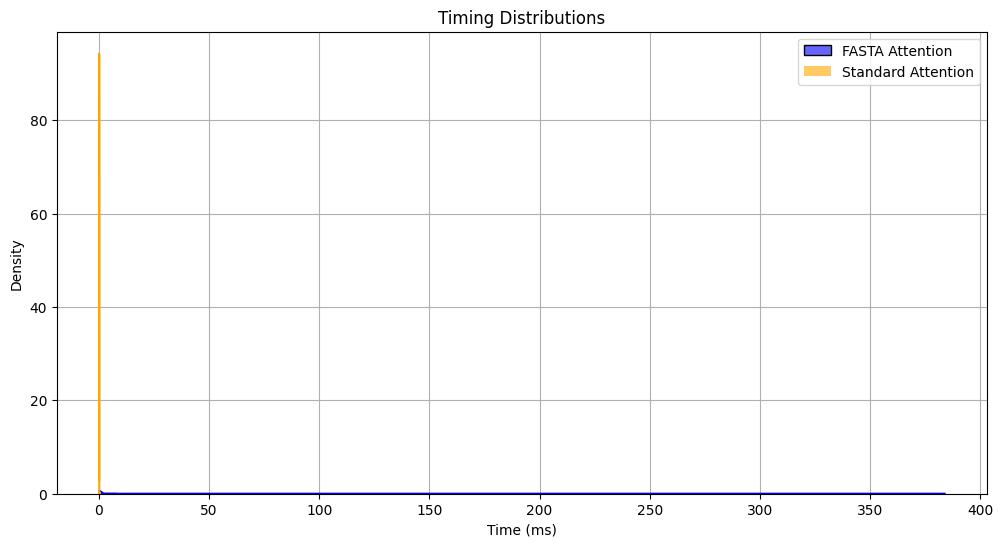

In [25]:
standard_outputs, fasta_outputs = test_fasta_attention_benchmark(N,D,block_size,num_iter)

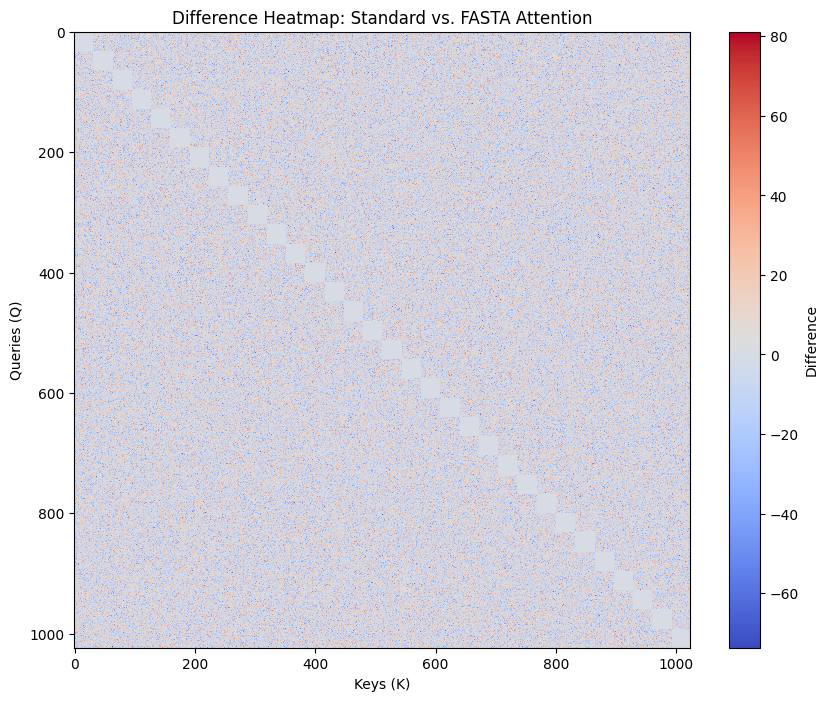

In [26]:
difference = (standard_outputs[0] - fasta_outputs[0])
# Create the heatmap for the first head
plt.figure(figsize=(10, 8))
plt.imshow(difference.squeeze(), cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Difference")
plt.title("Difference Heatmap: Standard vs. FASTA Attention")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")
plt.show()

In [27]:
matrix = standard_outputs[0] / fasta_outputs[0]  # The ratio matrix

# Get the number of grids in each dimension
num_grids_x = matrix.shape[1] // block_size
num_grids_y = matrix.shape[0] // block_size

# Initialize variables to track max ratio and its grid position
max_ratio = -np.inf
max_grid = (0, 0)

# Iterate over grids
for i in range(num_grids_y):
    for j in range(num_grids_x):
        # Extract the current grid
        grid = matrix[i * block_size:(i + 1) * block_size, j * block_size:(j + 1) * block_size]
        
        # Compute the maximum ratio in the grid
        grid_max = np.max(grid)
        
        
        # Update max_ratio and max_grid if this grid has a higher max
        if grid_max > max_ratio:
            max_ratio = grid_max
            max_grid = (i, j)

# Output the result
print(f"Maximum ratio is {max_ratio} in grid (row, col): {max_grid}")

Maximum ratio is 14161141.0 in grid (row, col): (6, 14)


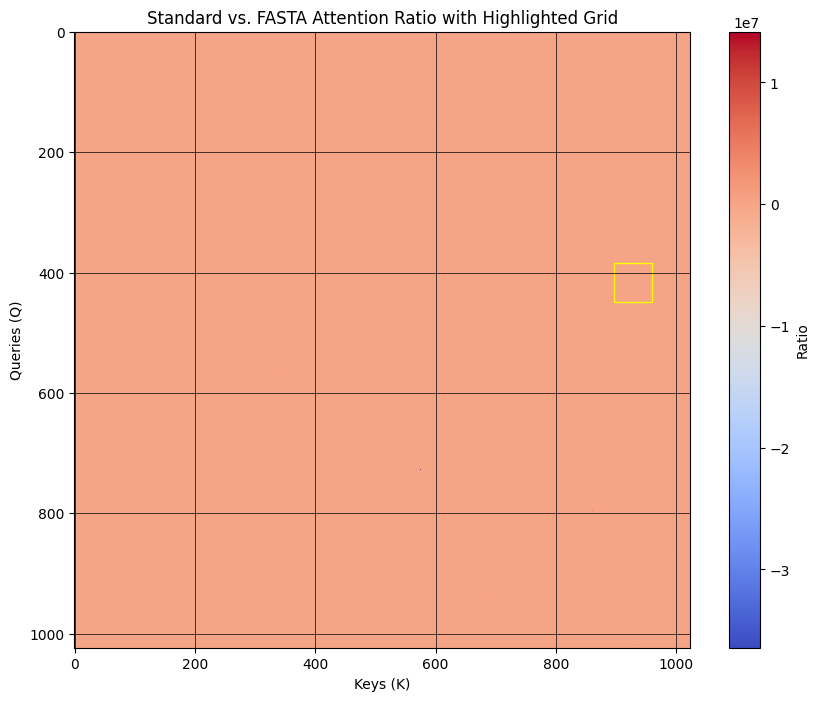

In [28]:
# Highlight the grid
plt.figure(figsize=(10, 8))
plt.imshow(standard_outputs[0] / fasta_outputs[0], cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Ratio")
plt.title("Standard vs. FASTA Attention Ratio with Highlighted Grid")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")

# Add grid lines
plt.grid(True, which='both', color='black', linestyle='-', linewidth=0.5)

# Highlight the grid
rect_x = max_grid[1] * block_size
rect_y = max_grid[0] * block_size
rect = plt.Rectangle((rect_x, rect_y), block_size, block_size, edgecolor='yellow', facecolor='none', lw=1)
plt.gca().add_patch(rect)

plt.show()

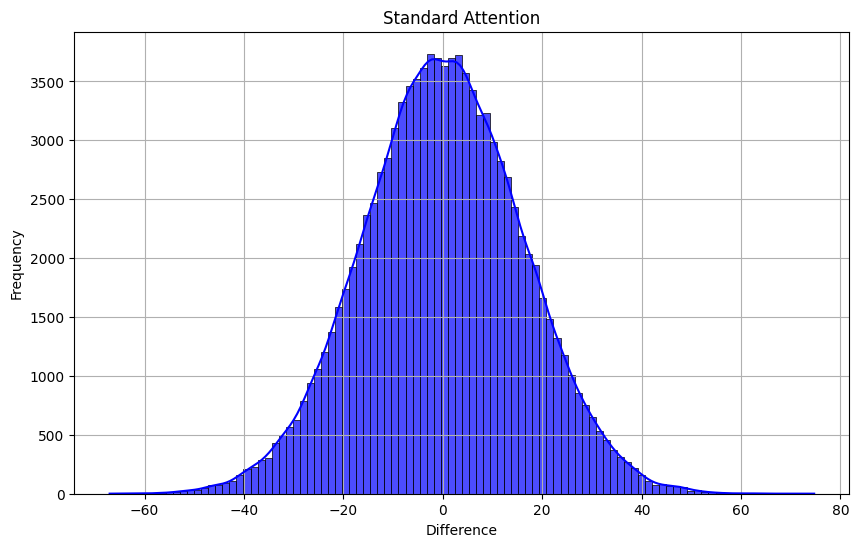

In [29]:
# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(standard_outputs[0].flatten()[::10], bins=100, kde=True, color='blue', alpha=0.7)
plt.title("Standard Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


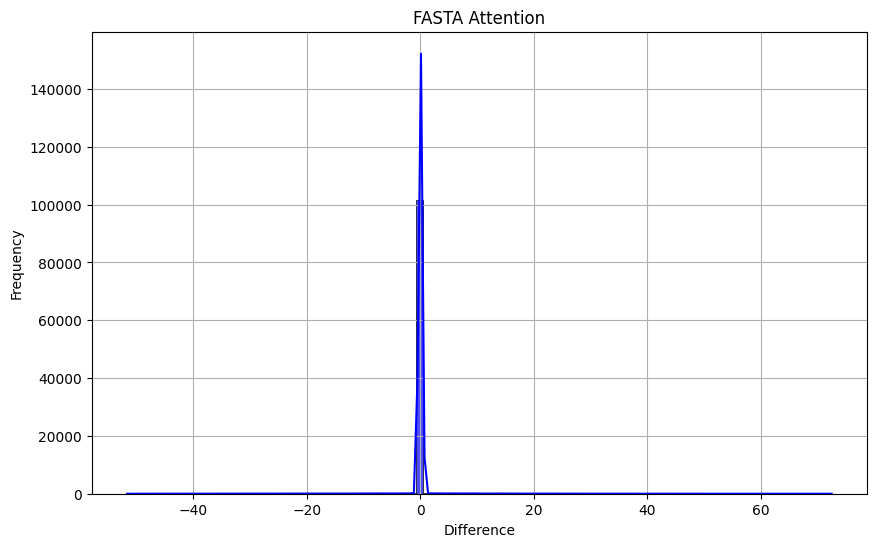

In [30]:
plt.figure(figsize=(10, 6))
sns.histplot(fasta_outputs[0].flatten()[::10], bins=100, kde=True, color='blue', alpha=0.7)
plt.title("FASTA Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

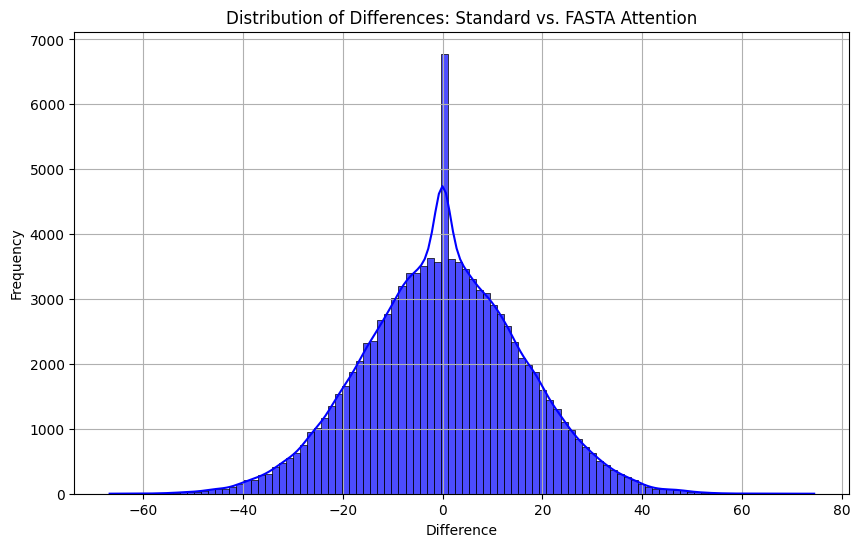

In [31]:
subsampled_difference = difference.flatten()[::10]  # Take every 10th value

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(subsampled_difference, bins=100, kde=True, color='blue', alpha=0.7)
plt.title("Distribution of Differences: Standard vs. FASTA Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

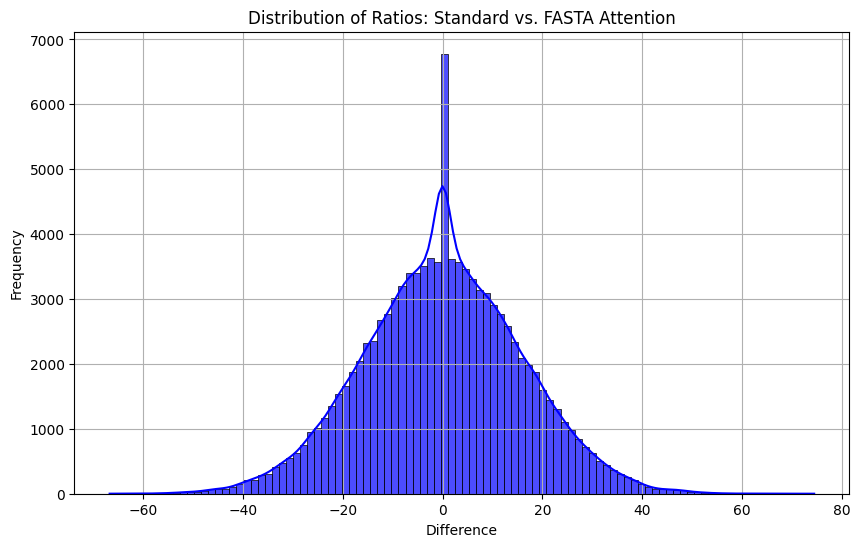

In [32]:
subsampled_ratio = (standard_outputs[0] / fasta_outputs[0]).flatten()[::10]  # Take every 10th value

# Create the distribution plot
plt.figure(figsize=(10, 6))
sns.histplot(subsampled_difference, bins=100, kde=True, color='blue', alpha=0.7)
plt.title("Distribution of Ratios: Standard vs. FASTA Attention")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [33]:
row_block_idx,col_block_idx = max_grid

# Compute Q indices
q_start = row_block_idx * block_size
q_end = (row_block_idx + 1) * block_size - 1

# Compute K indices
k_start = col_block_idx * block_size
k_end = (col_block_idx + 1) * block_size - 1

print(f"Q indices for block (row=6): {q_start} to {q_end}")
print(f"K indices for block (col=4): {k_start} to {k_end}")

Q indices for block (row=6): 384 to 447
K indices for block (col=4): 896 to 959


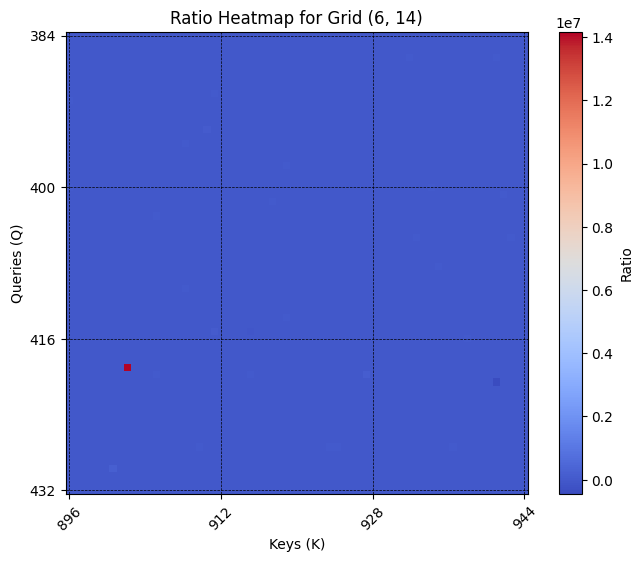

In [34]:
# Compute indices for the highlighted grid
q_start = max_grid[0] * block_size
q_end = (max_grid[0] + 1) * block_size
k_start = max_grid[1] * block_size
k_end = (max_grid[1] + 1) * block_size

# Extract the submatrix for the highlighted grid
highlighted_block = (standard_outputs[0] / fasta_outputs[0])[q_start:q_end, k_start:k_end]

# Generate x and y tick labels for indices
q_indices = np.arange(q_start, q_end, block_size // 4)  # Adjust granularity as needed
k_indices = np.arange(k_start, k_end, block_size // 4)

# Plot the heatmap for the highlighted block
plt.figure(figsize=(8, 6))
im = plt.imshow(highlighted_block, cmap='coolwarm', interpolation='nearest')
plt.colorbar(im, label="Ratio")
plt.title(f"Ratio Heatmap for Grid ({max_grid[0]}, {max_grid[1]})")
plt.xlabel("Keys (K)")
plt.ylabel("Queries (Q)")

# Set custom ticks for better index clarity
plt.xticks(ticks=np.linspace(0, block_size - 1, len(k_indices)), labels=k_indices, rotation=45)
plt.yticks(ticks=np.linspace(0, block_size - 1, len(q_indices)), labels=q_indices)

# Add grid lines for each block cell
plt.grid(True, which='both', linestyle='--', color='black', linewidth=0.5)

plt.show()